# Optimization with Masterful

**Author:** [Nikhil Gajendrakumar](mailto:nikhil@masterfulai.com)  
**Date created:** 2022/04/27  
**Last modified:** 2022/05/04  
**Description:** Optimization with Masterful

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)][1]&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[![Download](images/download.png)][2][Download this Notebook][2]

[1]:https://colab.research.google.com/github/masterfulai/masterful-docs/blob/main/notebooks/guide_batch_lr_finder.ipynb
[2]:http://docs.masterfulai.com/0.4.1/notebooks/guide_batch_lr_finder.ipynb

This is an introduction to Masterful's automatic solution to tune algorithmic hyperparameters. Hyperparameter such as learning rate and batch size control the training process of a model. Given these hyperparameters, the training algorithm learns the model parameters from the data. Picking the right values for these hyperparameters can be very painful. You take this ardous journey of trial-and-error where you try different values, run the training for few epochs, and pick the values that achieve the best validation accuracy. This process is very tedious and if you modify the model architecture, you will have to repeat the entire process again.

This guide will demonstrate how Masterful, algorithmically, picks the right values for these hyperparameters, for the given model and dataset, that can achieve the best performance in shortest training time.

## Prerequisites

Please follow the Masterful installation instructions [here](../tutorials/tutorial_installation.md)
in order to run this Quickstart.

## Imports

First, import the necessary libraries and register the Masterful package.

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from time import time
import masterful
masterful = masterful.register()

MASTERFUL: Your account has been successfully registered. Masterful v0.4.1 is loaded.


## Prepare the Data

For this guide, you will use SVHN (Street View House Numbers) dataset which is an image digit recognition dataset of digit images coming from real world data. Images are cropped to 32x32. The dataset consists of 73,257 images for training and 26,032 for testing.

You can verify that the data was downloaded correctly by displaying a few examples from the dataset. The first step in any ML project is some exploratory data analysis (EDA). The bare minimum is to visualize the images and understand their contents.

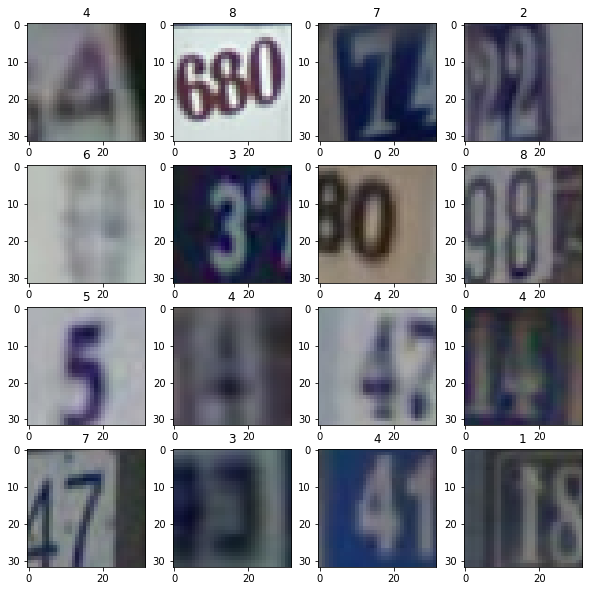

In [2]:
train_dataset = tfds.load("svhn_cropped",
                          split="train[:5%]",
                          as_supervised=True)
test_dataset = tfds.load("svhn_cropped",
                         split="test[:5%]",
                         as_supervised=True)

f, axarr = plt.subplots(4, 4, figsize=(10,10))

for i,(x,y) in enumerate(train_dataset.take(4*4)):
    row = i // 4
    col = i % 4
    axarr[row, col].imshow(x.numpy())
    axarr[row, col].title.set_text(f'{y.numpy()}')

In [3]:
# set image range to [0-1]
train_dataset = train_dataset.map(
    lambda image, label:
    (tf.cast(image, tf.float32) / 255.0, label),
    num_parallel_calls=tf.data.AUTOTUNE
)

test_dataset = test_dataset.map(
    lambda image, label:
    (tf.cast(image, tf.float32) / 255.0, label),
    num_parallel_calls=tf.data.AUTOTUNE
)

## Create the Model
For this example, we will use a simple model inspired by simple CNN used in
[this tensorflow tutorial](https://www.tensorflow.org/tutorials/images/cnn). This is a toy model for demonstration purposes only, and should not be used in a production environment. It has a few convolutional layers and outputs logits directly, rather than using a softmax layer at the end.

In [4]:
NUM_CLASSES = 10

def get_model():

  model = tf.keras.models.Sequential([
      tf.keras.layers.Input(shape=(32, 32, 3)),
      tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(NUM_CLASSES)
  ])

  return model

## Baseline Training

In order to measure the performance improvements from Masterful,
you should measure the performance of your model after training
with a standard training loop.

The hyperparameter values learning rate = 0.001 and batch size = 32
were picked since they are the most popular starting values that
have produced reasonable results across different model architectures
and datasets

In [5]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [6]:
# setup callback to log the total training time
class TrainingTime(tf.keras.callbacks.Callback):
    def __init__(self, batch_size, lr, logs=None):
        self.time_per_epoch = []
        self.batch_size = batch_size
        self.learning_rate = lr

    def on_epoch_begin(self, epoch, logs=None):
        self.starttime = time()

    def on_epoch_end(self, epoch, logs=None):
        self.time_per_epoch.append(time() - self.starttime)
        
    def on_train_end(self, logs=None):
        total_train_time = sum(self.time_per_epoch)
        msg = (f"Training time with batch size = {self.batch_size} and "
               f"learning rate = {self.learning_rate} is {total_train_time:.2f} s.")
        print(msg)
        

In [7]:
# set few common parameters for both experiments

epochs = 100
shuffle_buffer_size = 1024
optimizer = tfa.optimizers.LAMB(learning_rate=0.001)
lr_metric = get_lr_metric(optimizer)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.5,
                                                 patience=8)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12)

In [8]:
batch_size = 32
learning_rate = 0.001

tf.keras.backend.set_value(optimizer.lr, learning_rate)

base_model = get_model()
base_model.compile(optimizer=optimizer,
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy', lr_metric])


base_history = base_model.fit(train_dataset.shuffle(shuffle_buffer_size)
                              .batch(batch_size),
                              epochs=epochs,
                              validation_data=test_dataset.batch(64),
                              callbacks=[
                                  reduce_lr,
                                  early_stop,
                                  TrainingTime(batch_size,learning_rate)
                              ],
                              verbose=0)

msg = (f"Baseline model Train accuracy: {max(base_history.history['accuracy']):4f}, "
       f"and Test accuracy: {max(base_history.history['val_accuracy']):4f}")
print(msg)

Training time with batch size = 32 and learning rate = 0.001 is 122.04 s.
Baseline model Train accuracy: 0.991264, and Test accuracy: 0.791091


## Automatic hyperparameter value selection

The Masterful AutoML platform learns how to train your model by
focusing on five core organizational principles in deep
learning: architecture, data, optimization, regularization,
and semi-supervision.

In this guide we are only demostrating Masterful's optimizer and automatic
hyperparameter value selection, which is part of our optimization bucket,
and the performance benefit we acheive from the right hyperparameter values
alone in terms of training time and accuracy. Therefore we only run
Masterful apis that  are necessary to get the hyperparameter values and
train the model with a standard tensorflow training loop.

Masterful's meta-learner for optimization hyperparameters are tailored
to your model architecture and data. So the first thing to create
[ArchitectureParams](../api/api_architecture.rst#masterful.architecture.ArchitectureParams)
and [DataParams](../api/api_data.rst#masterful.data.DataParams) via their
respective learner functions. 

In the code below, you are telling Masterful that your model is 
performing a classification task (`masterful.enums.Task.CLASSIFICATION`) 
with 10 labels (`num_classes=NUM_CLASSES`), and that the 
input range of the image features going into your model are 
in the range [0,1] (`input_range=masterful.enums.ImageRange.ZERO_ONE`). 
Also, the model outputs logits rather than a softmax classification
 (`prediction_logits=True`).

In [9]:
# Start fresh with a new model
tf.keras.backend.clear_session()
model = get_model()

model_params = masterful.architecture.learn_architecture_params(
    model=model,
    task=masterful.enums.Task.CLASSIFICATION,
    input_range=masterful.enums.ImageRange.ZERO_ONE,
    num_classes=NUM_CLASSES,
    prediction_logits=True,
)
training_dataset_params = masterful.data.learn_data_params(
    dataset=train_dataset,
    task=masterful.enums.Task.CLASSIFICATION,
    image_range=masterful.enums.ImageRange.ZERO_ONE,
    num_classes=NUM_CLASSES,
    sparse_labels=True,
)

## Meta-Learning Optimization Hyperparameters

Now, call the learner for optimization hyperparameters. 

For more details on the optmization parameters, please see the [OptimizationParams](../api/api_optimization.rst#masterful.optimization.OptimizationParams) API specification.

To try our platform to train the model end to end, refer to our [Quick start guide](https://masterful-public.s3.us-west-1.amazonaws.com/933013963/0.4.1/notebooks/tutorial_quickstart.html#)



In [10]:
optimization_params = masterful.optimization.learn_optimization_params(
    model,
    model_params,
    train_dataset,
    training_dataset_params,
)

MASTERFUL: Learning optimal batch size.
MASTERFUL: Learning optimal initial learning rate for batch size 256.


## Training

In [15]:
batch_size = optimization_params.batch_size
learning_rate = optimization_params.learning_rate

# set starting optimizer learning rate
tf.keras.backend.set_value(optimizer.lr, learning_rate)
lr_metric = get_lr_metric(optimizer)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', lr_metric])

history = model.fit(train_dataset.shuffle(shuffle_buffer_size)
                    .batch(batch_size),
                    epochs=epochs,
                    validation_data=test_dataset.batch(64),
                    callbacks=[
                        reduce_lr,
                        early_stop,
                        TrainingTime(batch_size, learning_rate)
                    ],
                    verbose=0)

msg = (f"Masterful model Train accuracy: {max(history.history['accuracy']):4f}, "
       f"and Test accuracy: {max(history.history['val_accuracy']):4f}")
print(msg)

Training time with batch size = 256 and learning rate = 0.0035355337895452976 is 64.27 s.
Masterful model Train accuracy: 0.998635, and Test accuracy: 0.803379


As you can see, model trained with Masterful's hyperparameter achieved better training and test accuracy in 50% less training time, just by selecting the right values for batch size and learning rate. To learn more theory on how we automatically find these hyperparameter values, please refer [this blog post](https://www.masterfulai.com/blog/stop-burning-money-on-the-wrong-batch-size)

Masterful's full optimization suite can reduce training time and increase accuracy by many fold by customizing your training loop. To learn more on that, please check out our [docs](https://masterful-public.s3.us-west-1.amazonaws.com/933013963/0.4.1/index.html).

We would love to hear your thoughts on this guide or the entire Masterful platform. Join our [slack community]( https://www.masterfulai.com/community) and let us know what you think.